# Titanic: Machine Learning from Disaster
---


## Frame the problem
---
### Background
---
From the kaggle challenge page:
> The sinking of the Titanic is one of the most infamous shipwrecks in history.
>
> On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.
>
>While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.


>In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

### Dataset
---
Below is a table containing the contents of the dataset named `train.csv`:

| Variable  | Definition                                 	| Key                                            	|
|-----------|:----------------------------------------------|:--------------------------------------------------|
| Survived  | Survival                                   	| 0 = No, 1 = Yes                                	|
| Pclass   	| Ticket class                               	| 1 = 1st, 2 = 2nd, 3 = 3rd                      	|
| Sex      	| Sex                                        	|                                                	|
| Age      	| Age in years                               	|                                                	|
| SibSp    	| # of siblings / spouses aboard the Titanic 	|                                                	|
| Parch    	| # of parents / children aboard the Titanic 	|                                                	|
| Ticket   	| Ticket number                              	|                                                	|
| Fare     	| Passenger fare                             	|                                                	|
| Cabin    	| Cabin number                               	|                                                	|
| Embarked 	| Port of Embarkation                        	| C = Cherbourg, Q = Queenstown, S = Southampton 	|

## Set-up
---
Here, we set up all the paths and libraries used in the program, as well as important variables

In [205]:
import os,sys

globalT3Mbin = os.path.abspath(os.path.join(os.getcwd(),'..','..','bin'))
round1bin = os.path.abspath(os.path.join(os.getcwd(),'..','bin'))
if not (globalT3Mbin in sys.path):
    sys.path.append(globalT3Mbin)
if not (round1bin in sys.path):
    sys.path.append(round1bin)

In [206]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC,SVC
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from utilities import splitter

In [207]:
from pathlib import Path
data_folder_path = Path("../data")
training_set_path = data_folder_path / "train.csv"


In [208]:
seed = 1
plt.style.use('dark_background')
from sklearn import set_config
set_config(display='diagram')

## Gather Data
---


In [209]:
data_set = pd.read_csv(training_set_path)
feature_names = data_set.columns.values
label_names = ['Survived']
print("The names of the features are - " +str(feature_names))



The names of the features are - ['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


## Nature of Data
---
Here we investigate certain properties of the data which will affect the algorithm. This includes missing data, range of values, specialy types of values, what features are categorical etc.


In [210]:
print(data_set.info())
print(data_set.head().to_string())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 66.2+ KB
None
   PassengerId  Survived  Pclass                                                 Name     Sex   Age  SibSp  Parch            Ticket     Fare Cabin Embarked
0            1         0       3                              Braund, Mr. Owen Harr

There are a hanful of **missing** data values for the categories **Age, Embarked and Cabin**. 


In [211]:
print("The number of records missing ages is {0} and the number with missing ages and cabins is {1}"
    .format(data_set.Age.isnull().sum(),(data_set.Age.isnull() & data_set.Cabin.isnull()).sum()))
#TODO interpret this 



The number of records missing ages is 177 and the number with missing ages and cabins is 158


## Data Insights
---
### Distribution of features
First, let us observe what the dsitribution of features is.

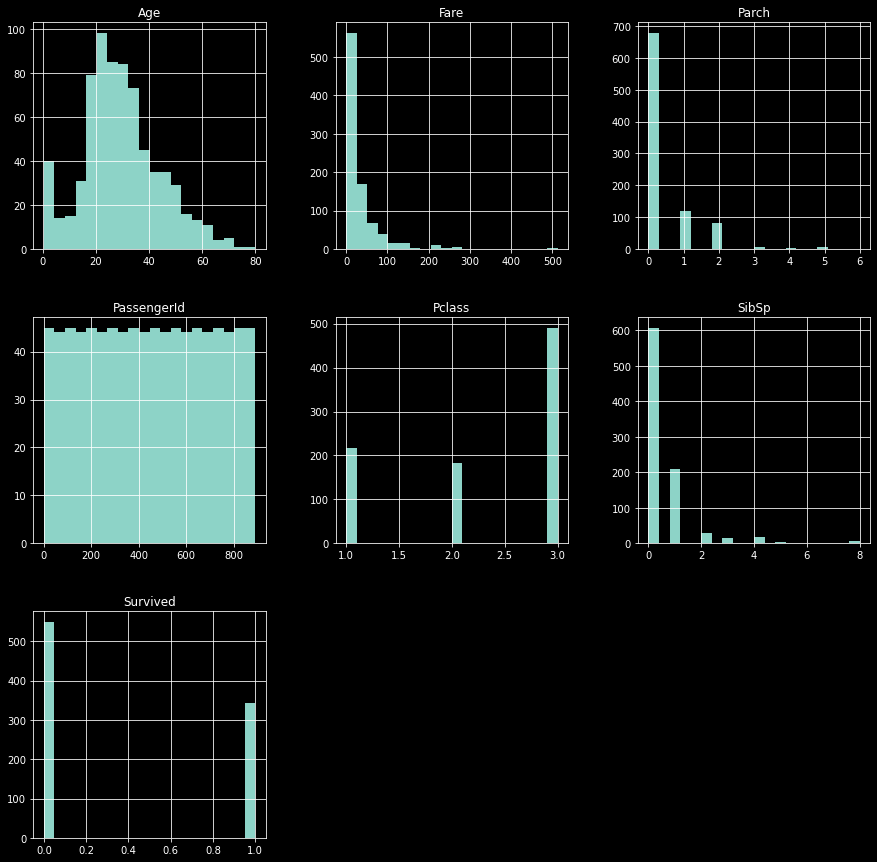

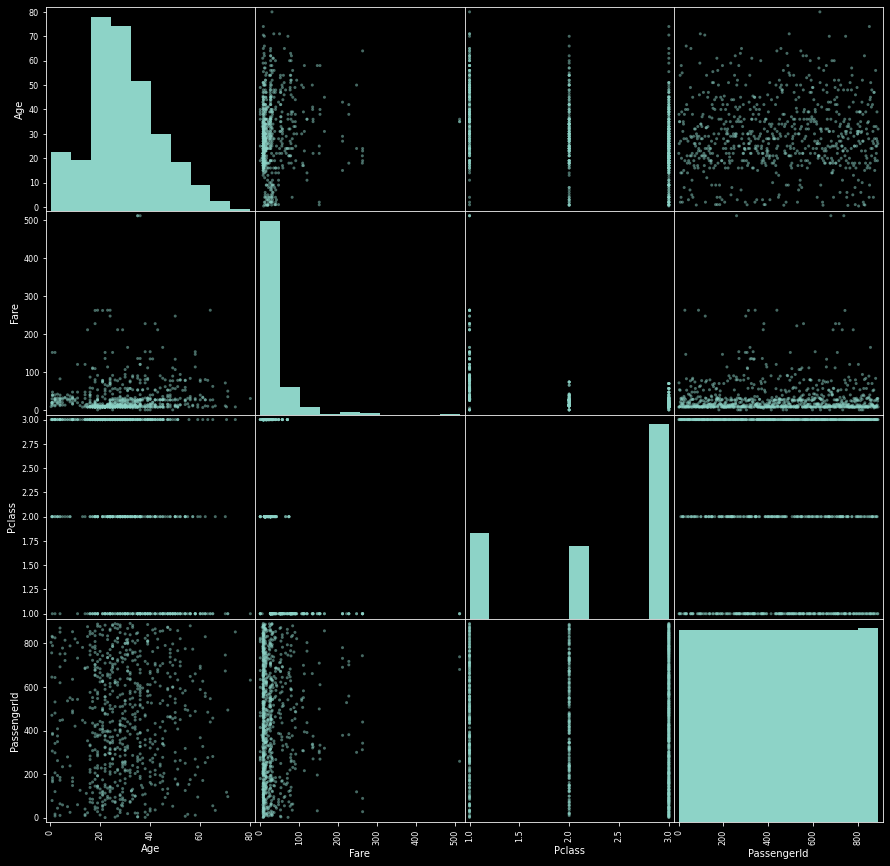

In [212]:
from pandas.plotting import scatter_matrix
data_set.hist(bins=20,figsize=(15,15))
plt.show()
scatter_matrix(data_set[["Age","Fare","Pclass","PassengerId"]],figsize=(15,15))
plt.show()

#### Some interesting thoughts:

1. There is no apparent relation between the PassengerId and Fare/Class. This could be for several reasons. Firstly, PassengerId could be assigned by the collectors of the dataset to identitify all passengers. Secondly, it could be because there is no apparent link between when the tickets were purchased and who got them. For now, I would like to conclude that there is no relation between "Fare" and "Pclass".
2. Interestingly, the cost of a certain class ticket is not the same for everyone. This is reflected in the range of fairs associated with each class. After further investigation, it is found that the better the class, the higher the fair and thus the larger the variation in cost. Also, it is interesting to see the imbalance in concentrations of age in the class.
3. There does seem to be a connection between PClass and Age. The younger the person is, the less wealthy, and hence the lower the class. 

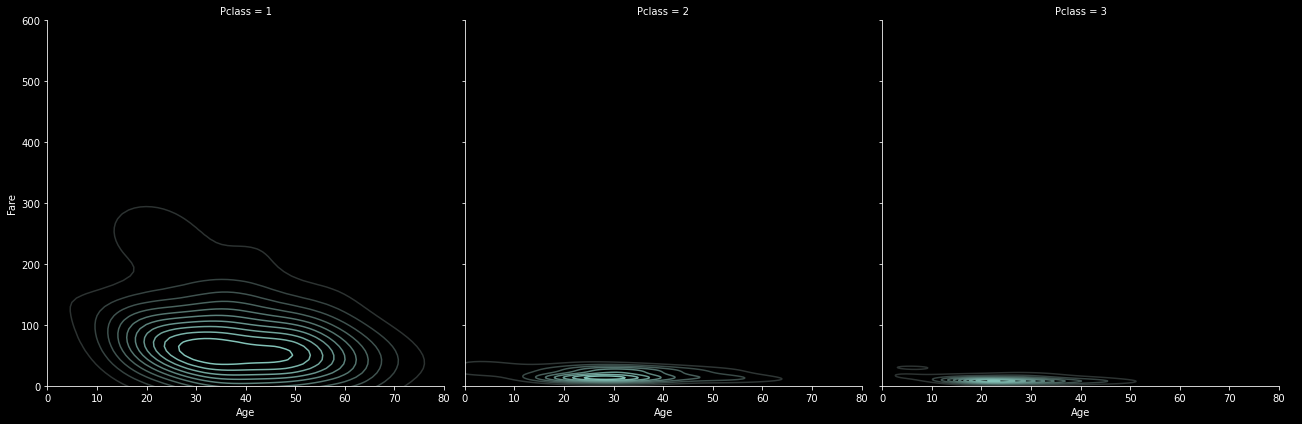

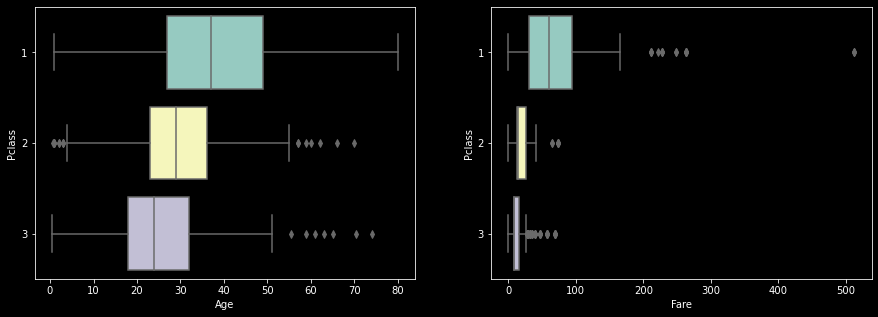

In [213]:
g = sns.FacetGrid(data_set,col="Pclass",size=6,xlim=(0,80),ylim=(0,600))
g = g.map(sns.kdeplot,"Age","Fare")
g.add_legend()
plt.show()
f,axes = plt.subplots(1,2,figsize=(15,5))
f = sns.boxplot(data=data_set,x='Age',y='Pclass',orient='h',ax=axes[0])
f = sns.boxplot(data=data_set,x='Fare',y='Pclass',orient='h',ax=axes[1])
plt.show()

### Correlation
Let us check what the correlation between different features is:

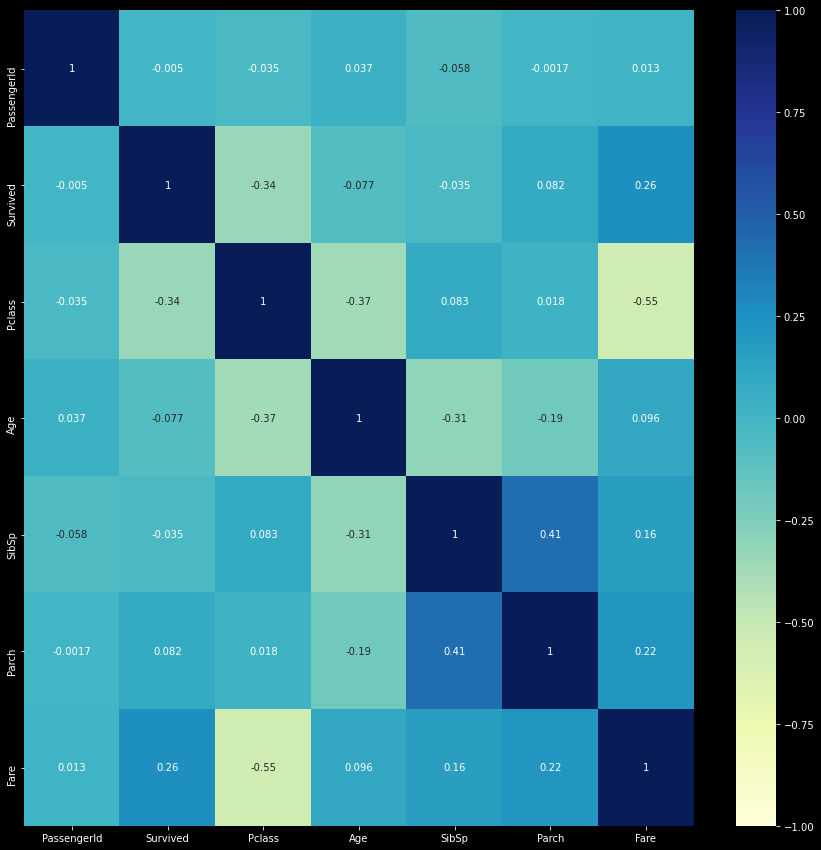

In [214]:
correlation_matrix = data_set.corr()
plt.figure(figsize=(15,15))
sns.heatmap(correlation_matrix,annot=True,vmin=-1,vmax=1,cmap='YlGnBu')
plt.show()

Lets look at the features which are most correlated:

1. **Pclass and Fare** - Naturally, the higher the class (i.e. smaller the number), the more expensive it is.
2. **SibSp and Parch** - This makes sense. If you have a spouse on board, then your children might be one as well, and if you have siblings on board, then you are likely to be a child and have your parents on board

As PClass is weakly correlated with age, I decided to check survival rates by passenger class of different age groups.

In [215]:
data_set
men = data_set.loc[data_set.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)

print("% of men who survived:", rate_men)

% of men who survived: 0.18890814558058924


In [216]:
print(type(data_set))
print(sum(data_set['Survived']), ' survived / ', len(data_set), ' total passengers\n\n')
mclasscount, mclasssurv = np.zeros(3), np.zeros(3)
fclasscount, fclasssurv = np.zeros(3), np.zeros(3)
magecount, magesurv = np.zeros(4), np.zeros(4)
fagecount, fagesurv = np.zeros(4), np.zeros(4)
for i in range (len(data_set)):
    if data_set['Sex'][i] == 'male':
        temp_class = data_set['Pclass'][i] - 1
        mclasscount[temp_class] = mclasscount[temp_class] + 1
        mclasssurv[temp_class] = mclasssurv[temp_class] + data_set['Survived'][i]

        if data_set['Age'][i] <= 16:
            magecount[0] = magecount[0] + 1
            magesurv[0] = magesurv[0] + data_set['Survived'][i]
        elif data_set['Age'][i] <= 25:
            magecount[1] = magecount[1] + 1
            magesurv[1] = magesurv[1] + data_set['Survived'][i]
        elif data_set['Age'][i] <= 40:
            magecount[2] = magecount[2] + 1
            magesurv[2] = magesurv[2] + data_set['Survived'][i]
        else:
            magecount[3] = magecount[3] + 1
            magesurv[3] = magesurv[3] + data_set['Survived'][i]

    elif data_set['Sex'][i] == 'female':
        temp_class = data_set['Pclass'][i] - 1
        fclasscount[temp_class] = fclasscount[temp_class] + 1
        fclasssurv[temp_class] = fclasssurv[temp_class] + data_set['Survived'][i]

        if data_set['Age'][i] <= 16:
            fagecount[0] = fagecount[0] + 1
            fagesurv[0] = fagesurv[0] + data_set['Survived'][i]
        elif data_set['Age'][i] <= 25:
            fagecount[1] = fagecount[1] + 1
            fagesurv[1] = fagesurv[1] + data_set['Survived'][i]
        elif data_set['Age'][i] <= 40:
            fagecount[2] = fagecount[2] + 1
            fagesurv[2] = fagesurv[2] + data_set['Survived'][i]
        else:
            fagecount[3] = fagecount[3] + 1
            fagesurv[3] = fagesurv[3] + data_set['Survived'][i]

#print('\nMale survival rate by class', mclasssurv / mclasscount)
#print('\nFemale survival rate by class', fclasssurv / fclasscount)

pclass_sex_array = pd.DataFrame([mclasssurv/mclasscount, fclasssurv/fclasscount], columns = ['1','2','3'], index = ['M', 'F']);
print('Survival rate class/sex\n', pclass_sex_array, '\n\n')

age_sex_array = pd.DataFrame([magesurv/magecount, fagesurv/fagecount], columns = ['0-16','17-25','26-40','41+'], index=['M','F']);
print('Survival rate age/sex\n', age_sex_array)

<class 'pandas.core.frame.DataFrame'>
342  survived /  891  total passengers


Survival rate class/sex
           1         2         3
M  0.368852  0.157407  0.135447
F  0.968085  0.921053  0.500000 


Survival rate age/sex
        0-16     17-25     26-40       41+
M  0.431373  0.117188  0.220930  0.150442
F  0.673469  0.739726  0.802198  0.722772


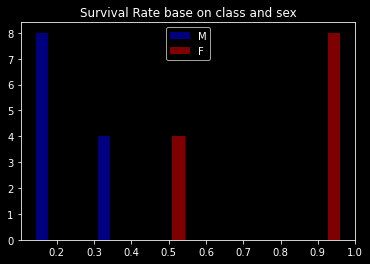

In [217]:
plt.hist([pclass_sex_array.loc['M'],pclass_sex_array.loc['F']],color=['b','r'], alpha=0.5,density=True,label=['M','F']) #Need better may of visuallizing
plt.legend()
plt.title("Survival Rate base on class and sex")
plt.show()

## Preparing data for algorithm
These are some initial steps taken to pre-process data.

---
### Remove unwanted features
I believe that **PassangerID** and **Name** will not be useful at the moment. Likewise, the **ticket** will not be used as lots of processing is required on it, and neither will **cabin** as only 1/4 of records have this information.

In [218]:
from transformers.FeatureSelector import FeatureSelector
cat_selector = FeatureSelector(['Sex','Embarked', 'Pclass'])
num_selector = FeatureSelector(['Age','SibSp','Parch','Fare'])# should pclass be numerical or categorical? - I think it should be categorical (NN)
cat_selector.fit_transform(data_set)

array([['male', 'S', 3],
       ['female', 'C', 1],
       ['female', 'S', 3],
       ...,
       ['female', 'S', 3],
       ['male', 'C', 1],
       ['male', 'Q', 3]], dtype=object)

### Fix missing values

In [219]:
from sklearn.impute import SimpleImputer
cat_imputer = SimpleImputer(strategy='most_frequent')
num_imputer = SimpleImputer(strategy='mean')

### Encoding categorical data

In [220]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()

### Feature Scaling

In [221]:
from sklearn.preprocessing import StandardScaler
num_scalar = StandardScaler()

### Pipeline

In [222]:
from sklearn.pipeline import Pipeline,FeatureUnion
num_pipeline = Pipeline([('selector',num_selector),('imputer',num_imputer),('scalar',num_scalar)])
cat_pipeline = Pipeline([('selector',cat_selector),('imputer',cat_imputer),('encoder',cat_encoder)])
full_pipeline = FeatureUnion(transformer_list=[('num_pipeline',num_pipeline),('cat_pipeline',cat_pipeline)])

### Splitting the data

In [223]:
data_set_X, data_set_Y = splitter.split_from_labels(data_set,label_names)

training_set, validation_set, test_set = splitter.split_tvt_set(data_set,[4,0,1],seed)
training_set_X, training_set_Y = splitter.split_from_labels(training_set,label_names)
test_set_X, test_set_Y = splitter.split_from_labels(test_set,label_names)

training_set_X_trans = full_pipeline.fit_transform(training_set_X)
test_set_X_trans = full_pipeline.fit_transform(test_set_X)

## Logistic regression

In [231]:
model = LogisticRegression(solver = 'liblinear', random_state=0)
#Will change parameters here according to data analysis
model.fit(training_set_X_trans, training_set_Y) 
y_pred = model.predict(test_set_X_trans)
print(model.score(test_set_X_trans, test_set_Y))

0.8120617110799438


## Support Vector Machine



In [225]:
svm = SVC()
np.mean(cross_val_score(svm, training_set_X_trans,training_set_Y,cv=10,scoring="f1"))
gd = GridSearchCV(svm,param_grid={'C': [1, 3,10,30,100],'kernel':['linear', 'poly', 'rbf', 'sigmoid'],'degree':[1,2,3,4,5]})
gd.fit(training_set_X_trans,training_set_Y)
gd.best_score_

0.8273219738008472